# Data Preparation and Initial Analysis

Here we focus on preparing and analyzing health indicator data for diabetes from the years 2015 and 2021. The goal is to combine these datasets to form a comprehensive view of the data, which can later be used for machine learning modeling. The following steps are taken:

1. Import Libraries
2. Load the Data
3. Combine the DataFrames
4. Rename the column 'Diabetes_binary' for brevity

In [ ]:
# import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn import linear_model, metrics, model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)


from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler

df1 = pd.read_csv('BRFSS2015.csv')
df2 = pd.read_csv('BRFSS2021.csv')

# Combine the two DataFrames
combined_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# Rename the 'Diabetes_binary' column to 'Diabetes'
combined_df.rename(columns={"Diabetes_binary": "Diabetes"}, inplace=True)

# Display the first few rows of the combined dataframe
# and its shape to verify the combination
combined_df_info = combined_df.head(), combined_df.shape

combined_df_info  # output

(   Diabetes  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
 0       0.0     1.0       0.0        1.0  26.0     0.0     0.0   
 1       0.0     1.0       1.0        1.0  26.0     1.0     1.0   
 2       0.0     0.0       0.0        1.0  26.0     0.0     0.0   
 3       0.0     1.0       1.0        1.0  28.0     1.0     0.0   
 4       0.0     0.0       0.0        1.0  29.0     1.0     0.0   
 
    HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
 0                   0.0           1.0     0.0  ...            1.0   
 1                   0.0           0.0     1.0  ...            1.0   
 2                   0.0           1.0     1.0  ...            1.0   
 3                   0.0           1.0     1.0  ...            1.0   
 4                   0.0           1.0     1.0  ...            1.0   
 
    NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
 0          0.0      3.0       5.0      30.0       0.0  1.0   4.0        6.0   
 1          0.

# Removing Features¶
Here we remove features deemed irrelevant for modeling purposes. We specify a list of columns to be removed and then drop these columns from the combined DataFrame.

We reverse the values of the "General Health" feature to make it more clear to the audience when graphed. This makes a value of 5 = "excellent" and value of 1 = "poor".

In [ ]:
# Remove irrelevant features from the combined dataset
columns_to_remove = ["CholCheck", "AnyHealthcare", "NoDocbcCost", "Education", "Income"]
reduced_df = combined_df.drop(columns=columns_to_remove)

# Reverse the values of 'GenHlth'
reduced_df["GenHlth"] = 6 - reduced_df["GenHlth"]

# Display the first few rows of the reduced dataframe to verify the removal
reduced_df.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0
1,0.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0
2,0.0,0.0,0.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,5.0,0.0,10.0,0.0,1.0,13.0
3,0.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0
4,0.0,0.0,0.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,8.0


# Check for Missing Values¶
Here we check for missing values in the combined dataset. Note there are NO missing values found.

In [ ]:
# Check for missing values in the reduced dataset
missing_values = reduced_df.isnull().sum()

missing_values  ## no missing values found

Diabetes                0
HighBP                  0
HighChol                0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
dtype: int64

# Data Type Optimization Analysis¶
Here we perform a preliminary analysis aimed at optimizing data storage and processing efficiency by examining the range of values for selected features within the reduced dataset. Here we see that all numerical values are well within the range of an 8-bit integer (this dataset has no numbers with decimal values).

We also calculate the memory used before we adjust the data types-- this is our baseline for memory usage.

In [ ]:
# Check range of values of specified features to determine suitable data types
features_to_optimize = ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age"]
data_types_optimization = (
    reduced_df[features_to_optimize].describe().loc[["min", "max"]]
)

# Memory used before reducing data types
memory_before = reduced_df.memory_usage(index=True).sum()

data_types_optimization

,BMI,GenHlth,MentHlth,PhysHlth,Age
min,12.0,1.0,0.0,0.0,1.0
max,99.0,5.0,30.0,30.0,13.0


# Data Type Conversion for Efficiency¶
We enhance the dataset's memory efficiency by converting specified binary columns to boolean data types. We print the memory usage before and after the operation to demonstrate the effectiveness of this optimization in reducing the dataset's memory consumption.

In [ ]:
# scale data types down to reduce memory footprint
reduced_df["BMI"] = reduced_df["BMI"].astype("float32")
reduced_df["GenHlth"] = reduced_df["GenHlth"].astype("int8")
reduced_df["MentHlth"] = reduced_df["MentHlth"].astype("int8")
reduced_df["PhysHlth"] = reduced_df["PhysHlth"].astype("int8")
reduced_df["Age"] = reduced_df["Age"].astype("int8")

# convert 1/0 binary columns to boolean values
binary_columns = [
    "Diabetes",
    "HighBP",
    "HighChol",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "DiffWalk",
    "Sex",
]
for column in binary_columns:
    reduced_df[column] = reduced_df[column].astype("bool")

# memory size after data type reduction
memory_after = reduced_df.memory_usage(index=True).sum()

print("Dataframe memory used before:", memory_before)
print("Dataframe memory used after:  ", memory_after)

Dataframe memory used before: 18744736
Dataframe memory used after:   2756688


# Data Exploration¶
Next we generate some visuals to explore some possible relationships in the data. We will look at Histograms and Scatterplots.

# Histogram Figure 1.a¶
Here we generate a histogram that compares the distribution of general health ratings (GenHlth) between individuals with and without diabetes (Diabetes status) in the dataset. For each group, we display the frequency of respondents across five health rating categories, ranging from poor to excellent health, after these ratings have been reversed so that higher numbers indicate better health. The histogram for individuals without diabetes is shown in blue, while the histogram for those with diabetes is in orange, allowing for a visual comparison of how general health perceptions differ between these two groups. This visualization aids in understanding whether there's a noticeable difference in self-reported general health status among individuals based on their diabetes condition.

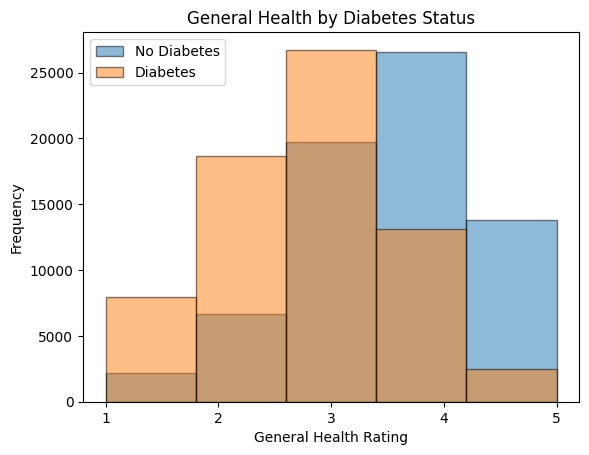

In [ ]:
# Filter the dataset by Diabetes status
gen_health_no_diabetes = reduced_df[reduced_df["Diabetes"] == False]["GenHlth"]
gen_health_with_diabetes = reduced_df[reduced_df["Diabetes"] == True]["GenHlth"]

# Plot histograms
plt.hist(
    gen_health_no_diabetes, bins=5, alpha=0.5, label="No Diabetes", edgecolor="black"
)
plt.hist(
    gen_health_with_diabetes, bins=5, alpha=0.5, label="Diabetes", edgecolor="black"
)

# Add legend
plt.legend()

# Add titles and labels as needed
plt.title("General Health by Diabetes Status")
plt.xlabel("General Health Rating")
plt.ylabel("Frequency")

# Set x-axis to display integer values from 1 to 5
plt.xticks(range(1, 6))

# Show the plot
plt.show()

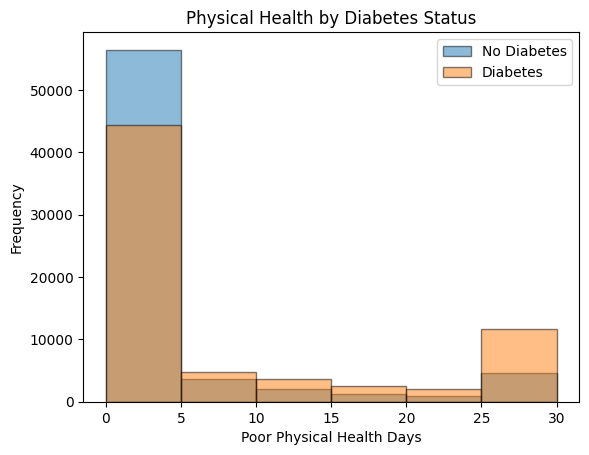

In [ ]:
# Filter the dataset by Diabetes status
phys_health_no_diabetes = reduced_df[reduced_df["Diabetes"] == False]["PhysHlth"]
phys_health_with_diabetes = reduced_df[reduced_df["Diabetes"] == True]["PhysHlth"]

# Plot histograms
plt.hist(
    phys_health_no_diabetes, alpha=0.5, label="No Diabetes", bins=6, edgecolor="black"
)
plt.hist(
    phys_health_with_diabetes, alpha=0.5, label="Diabetes", bins=6, edgecolor="black"
)

# Add legend
plt.legend()

# Add titles and labels as needed
plt.title("Physical Health by Diabetes Status")
plt.xlabel("Poor Physical Health Days")
plt.ylabel("Frequency")

# Show the plot
plt.show()

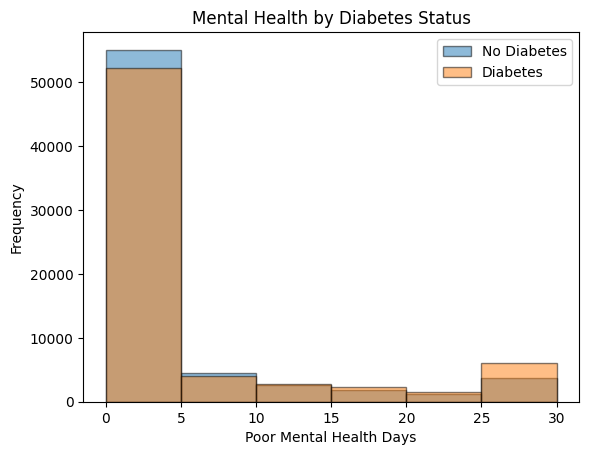

In [ ]:
# Filter the dataset by Diabetes status
phys_health_no_diabetes = reduced_df[reduced_df["Diabetes"] == False]["MentHlth"]
phys_health_with_diabetes = reduced_df[reduced_df["Diabetes"] == True]["MentHlth"]

# Plot histograms
plt.hist(
    phys_health_no_diabetes, alpha=0.5, label="No Diabetes", bins=6, edgecolor="black"
)
plt.hist(
    phys_health_with_diabetes, alpha=0.5, label="Diabetes", bins=6, edgecolor="black"
)

# Add legend
plt.legend()

# Add titles and labels as needed
plt.title("Mental Health by Diabetes Status")
plt.xlabel("Poor Mental Health Days")
plt.ylabel("Frequency")
# Show the plot
plt.show()

# Age distribution¶
Here we provide a visual distribution analysis of the Age feature. Of note, the data was collected using a 13-level age category where 1 = 18-24, 9 = 60-64, and 13 = 80 or older.

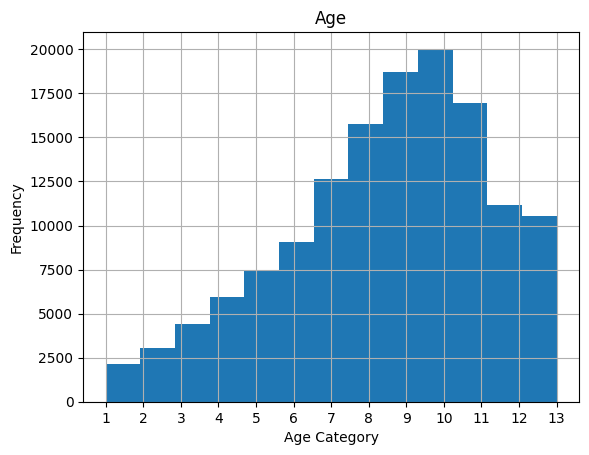

In [ ]:
# Plot Age histogram
graph_histograms = reduced_df.hist(column="Age", grid=True, bins=13)

# Calculate the tick positions for 13 bins
tick_positions = range(1, 14)

# Set the x-axis ticks
plt.xticks(tick_positions)

# Optionally, set x-axis and y-axis labels
plt.xlabel("Age Category")
plt.ylabel("Frequency")

# Show the plot
plt.show()

# BMI over Age¶
Here we see that diabetics have a higher BMI on average.

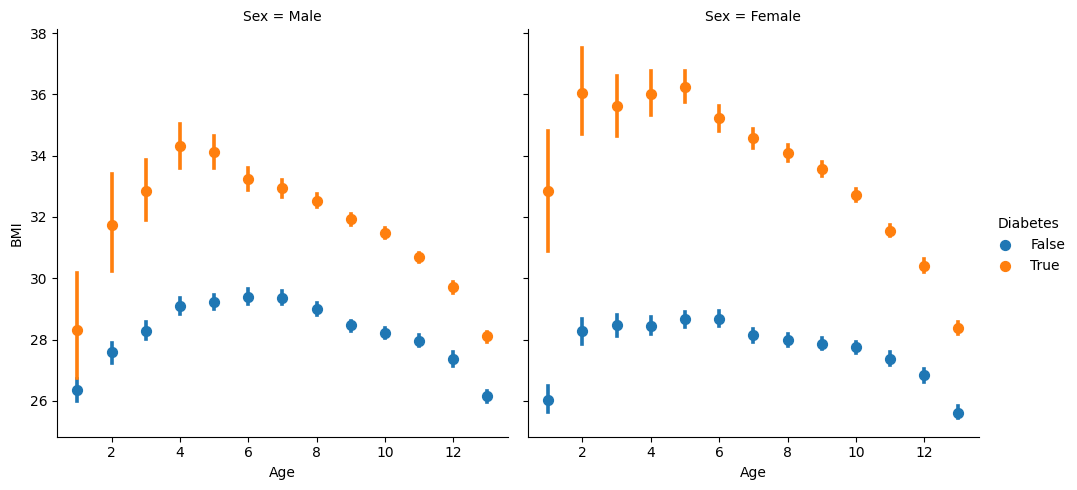

In [ ]:
# Copy the DataFrame to avoid modifying the original data
plot_df = reduced_df.copy()

# Map True/False to Male/Female
plot_df["Sex"] = plot_df["Sex"].map({True: "Male", False: "Female"})

# Age/BMI Scatterplot
sns.lmplot(
    data=plot_df,
    x="Age",
    y="BMI",
    col="Sex",
    hue="Diabetes",
    x_bins=1000,
    fit_reg=False,
)

# General Health over Age¶
The general health indicator is actually reversed; a score of 5 is poor, a score of 1 is excellent. Here we see that diabetics have poorer general health. We also see a trend in healthy people where the older one gets, the poorer their overall health. Diabetics do not show this trend.

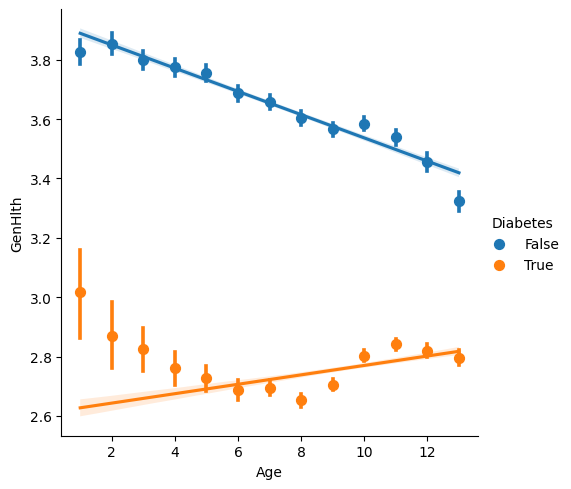

In [ ]:
# Age/General-Health Scatterplot
sns.lmplot(data=reduced_df, x="Age", y="GenHlth", hue="Diabetes", x_bins=1000)

# Physical Health as compared to Mental health¶
Here we see a trend that the more days per month of poor mental health an individual has, the more days on average of physical health they will experience. Of note is diabetics have a similar distribution of poor mental health days, but significantly more days per month of poor physical health.

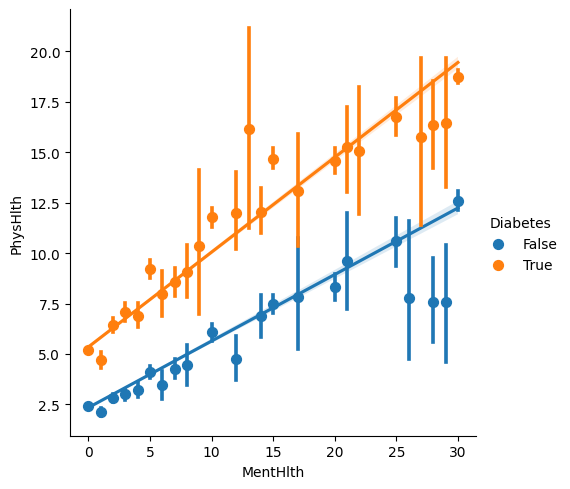

In [ ]:
# Health Scatterplot
sns.lmplot(data=reduced_df, x="MentHlth", y="PhysHlth", hue="Diabetes", x_bins=1000)

# Logistic Regression Model for Diabetes Prediction¶
Here we prepare data for machine learning, specifically using a logistic regression model to predict diabetes. First, numerical columns are identified and scaled using MinMaxScaler to ensure all features contribute equally to the model without bias from varying scales. A logistic regression model is then initialized with specific parameters. The dataset is split into features (X_log) and the target variable (y_log). The data is further divided into training and test sets to evaluate the model's performance on unseen data.

After training the logistic regression model, predictions are made on the test set. The model's effectiveness is assessed using accuracy, confusion matrix, and classification report, providing a comprehensive overview of its predictive capabilities in distinguishing between diabetic and non-diabetic individuals.

In [ ]:
# copy Dataframe for Logistic model
log_df = reduced_df.copy(deep=True)

# Selecting numerical columns (excluding binary/boolean columns)
numerical_columns = ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age"]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical features
log_df[numerical_columns] = scaler.fit_transform(log_df[numerical_columns])

mylog_model = linear_model.LogisticRegression(solver="saga", max_iter=1000)

# 'X' is the feature set and 'y' is the target variable
X_log = log_df.drop("Diabetes", axis=1)
y_log = log_df["Diabetes"].astype("bool")  # Ensuring the target is boolean

# Splitting the dataset into the Training set and Test set
X_log_train, X_log_test, y_log_train, y_log_test = model_selection.train_test_split(
    X_log, y_log, test_size=0.25, random_state=42
)
# Train the model and output prediction of test data
mylog_model.fit(X_log_train, y_log_train)
y_pred_log = mylog_model.predict(X_log_test)

# Evaluate the model
accuracy_log = accuracy_score(y_log_test, y_pred_log)
conf_matrix_log = confusion_matrix(y_log_test, y_pred_log)
class_report_log = classification_report(y_log_test, y_pred_log)

print("\nLogistic Regression (single) prediction results:", "\n")
print(f"Accuracy: {round(accuracy_log*100,2)} %", "\n")
print("Confusion Matrix:")
print(conf_matrix_log, "\n")
print("Classification Report:")
print(class_report_log)


Logistic Regression (single) prediction results: 

Accuracy: 74.59 % 

Confusion Matrix:
[[12557  4656]
 [ 4101 13143]] 

Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.73      0.74     17213
        True       0.74      0.76      0.75     17244

    accuracy                           0.75     34457
   macro avg       0.75      0.75      0.75     34457
weighted avg       0.75      0.75      0.75     34457



# Random Forest Model for Comparison¶
Here we set up a second model using the Random Forest algorithm to compare with our Logistic Regression model. The steps are much the same as before, however we do not need to scale the numerical data.

In [ ]:
# 'X' is the set of features and 'y' is the target variable
X_rf = reduced_df.drop("Diabetes", axis=1)
y_rf = reduced_df["Diabetes"].astype("bool")  # Ensuring the target is boolean

# Splitting the dataset into the Training set and Test set
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_rf, y_rf, test_size=0.25, random_state=42
)

# Creating a Random Forest Classifier -- You can adjust parameters
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting Random Forest to the Training set
rf_classifier.fit(X_rf_train, y_rf_train)

# Predicting the Test set results
y_pred_rf = rf_classifier.predict(X_rf_test)

accuracy_rf = accuracy_score(y_rf_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_rf_test, y_pred_rf)
class_report_rf = classification_report(y_rf_test, y_pred_rf)

# Evaluate the model
print("\nRandom Forest (single) prediction results:", "\n")
print(f"Accuracy: {round(accuracy_rf*100,2)} %", "\n")
print("Confusion Matrix:")
print(conf_matrix_rf, "\n")
print("Classification Report:")
print(class_report_rf)


Random Forest (single) prediction results: 

Accuracy: 72.13 % 

Confusion Matrix:
[[11906  5307]
 [ 4297 12947]] 

Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.69      0.71     17213
        True       0.71      0.75      0.73     17244

    accuracy                           0.72     34457
   macro avg       0.72      0.72      0.72     34457
weighted avg       0.72      0.72      0.72     34457



# Cross-Validation of Models¶
Next we perform a cross-validation process on the logistic regression and Random Forest models to verify their reliability across different subsets of the dataset. By utilizing the KFold method with 5 splits and shuffling enabled, the dataset is divided into distinct subsets to conduct multiple training and testing cycles. The average of these scores is calculated and displayed, offering a robust measure of the model's overall performance. This approach helps to ensure that the model's predictive accuracy is not overly dependent on any particular partition of the data, thereby increasing confidence in its generalizability.

In [ ]:
# Verify model by averaging different test/train splits
k_folds = KFold(n_splits=5, shuffle=True)
# The number of folds determines the test/train split for each iteration.
# So 5 folds has 5 different mutually exclusive training sets.
# That's a 1 to 4 (or .20 to .80) testing/training split for each of the 5 iterations.

# This is the average score. Print 'scores' to see array of individual iteration scores.
log_scores = cross_val_score(mylog_model, X_log, y_log)
rf_scores = cross_val_score(rf_classifier, X_rf, y_rf)

# Output average scores
print(
    "Logistic Regression Average Prediction Score: ",
    round(log_scores.mean() * 100, 2),
    "%",
)
print("Random Forest Average Prediction Score: ", round(rf_scores.mean() * 100, 2), "%")

Logistic Regression Average Prediction Score:  74.26 %
Random Forest Average Prediction Score:  71.89 %


# Confusion Matrix Visual¶
Confusion matrixes are used to evaluate the performance in classifying diabetic and non-diabetic individuals. Here we look at the Logistic Regression model, because it proved to be more accurate. More importantly, it had less false-negative outcomes compared to the random forest model (4101 vs 4297).

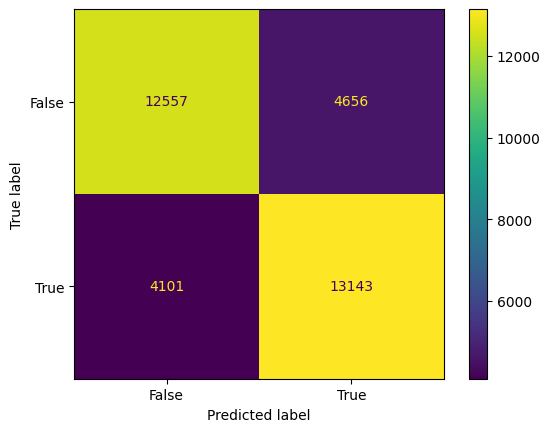

In [ ]:
# Plot confusion matrix
graph_confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_log_test, y_pred_log)

# Patient Outcome Prediction¶
This here is the objective of this project: to predict whether or not a patient is at risk of diabetes. The user enters the various health indicators, clicks the button and gets a prediction printed below.

In [ ]:
# USER INTERFACE: form for input for patient prediction
import ipywidgets as widgets

# Map string labels to numerical values
yesno_options_dict = {"No": 0, "Yes": 1}
mf_options_dict = {"Female": 0, "Male": 1}

# 'features' is the list of features used by your model.
features = [
    "HighBP",
    "HighChol",
    "BMI",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "GenHlth",
    "MentHlth",
    "PhysHlth",
    "DiffWalk",
    "Sex",
    "Age",
]

# 'widget_items' is a dictionary mapping feature to description
widget_items = {
    "Sex": "Sex",
    "Age_label": "Age category (1 = 18-24, 4 = 35-39, 8 = 55-59, 13 = 80 or older) :",
    "Age": "",
    "BMI_label": "Body Mass Index :",
    "BMI": "",
    "HighBP": "High Blood Pressure",
    "HighChol": "High Cholesterol",
    "Smoker": "Have you smoked at least 100 cigarettes in your life?",
    "HvyAlcoholConsump": "Heavy drinkers (drinks <14 for men, <7 for women per week",
    "Stroke": "(Ever told) you had a Stroke?",
    "HeartDiseaseorAttack": "Heart Disease or Attack (CHD or MI)",
    "GenHlth_label": "General Health scale :",
    "GenHlth": "",
    "MentHlth_label": "How many past days was your Mental Health not good?",
    "MentHlth": "",
    "PhysHlth_label": "How many past days was your Physical Health not good?",
    "PhysHlth": "",
    "DiffWalk": "Do you have Difficulty Walking or climbing stairs?",
    "PhysActivity": "Physical Activity in past 30 days, not incl job",
    "Fruits": "Eat 1 Fruit or more per day",
    "Veggies": "Eat Veggies 1 or more per day",
}

widgets_dict = {}

# Create widgets for each feature
for item in widget_items.keys():
    if item in [
        "HighBP",
        "HighChol",
        "Smoker",
        "Stroke",
        "HeartDiseaseorAttack",
        "PhysActivity",
        "Fruits",
        "Veggies",
        "HvyAlcoholConsump",
        "DiffWalk",
    ]:
        # Binary features: create a dropdown with options 'Yes' and 'No'
        widgets_dict[item] = widgets.RadioButtons(
            options=yesno_options_dict,
            value=0,
            description=widget_items.get(item) + " : ",
        )
    if item == "Sex":
        # Create a dropdown with options 'Male' and 'Female'
        widgets_dict[item] = widgets.RadioButtons(
            options=mf_options_dict,
            value=0,
            description=widget_items.get(item) + " : ",
        )
    if item == "BMI":
        widgets_dict[item] = widgets.FloatSlider(
            value=20.0,
            min=10,
            max=50.0,
            step=0.1,
            description=widget_items.get(item),
        )
    if item in ["GenHlth", "MentHlth", "PhysHlth"]:
        widgets_dict[item] = widgets.FloatSlider(
            value=0,
            min=0,
            max=30,
            step=1,
            description=widget_items.get(item),
        )
    if item == "Age":
        widgets_dict[item] = widgets.FloatSlider(
            value=8,
            min=1,
            max=13,
            step=1,
            description=widget_items.get(item),
        )
    if item in [
        "Age_label",
        "BMI_label",
        "GenHlth_label",
        "MentHlth_label",
        "PhysHlth_label",
    ]:
        widgets_dict[item] = widgets.Label(widget_items.get(item))


# Button to make prediction
predict_btn = widgets.Button(description="Predict Patient Risk")

# Output widget to display prediction result
output = widgets.Output()


def on_predict_btn_clicked(b):
    # Prepare the input for the model
    input_data = [widgets_dict[feature].value for feature in features]
    input_data = np.array(input_data).reshape(1, -1)

    # Create a DataFrame with input_data and assign column names using features
    input_df = pd.DataFrame(input_data, columns=features)
    # Ensure the DataFrame columns are in the correct order
    input_df = input_df[X_log.columns]

    # Apply the same scaling to the input as was done to the training data
    input_df[numerical_columns] = scaler.transform(input_df[numerical_columns])

    #### Make prediction ####
    prediction = mylog_model.predict(input_df)

    # Display prediction
    with output:
        output.clear_output()
        if prediction[0] == 0:
            print("Prediction: Not at risk of diabetes")
        else:
            print("Prediction: At risk of diabetes")


predict_btn.on_click(on_predict_btn_clicked)

# Display widgets
for widget in widgets_dict.values():
    display(widget)
display(predict_btn, output)

RadioButtons(description='Sex : ', options={'Female': 0, 'Male': 1}, value=0)

Label(value='Age category (1 = 18-24, 4 = 35-39, 8 = 55-59, 13 = 80 or older) :')

FloatSlider(value=8.0, max=13.0, min=1.0, step=1.0)

Label(value='Body Mass Index :')

FloatSlider(value=20.0, max=50.0, min=10.0)

RadioButtons(description='High Blood Pressure : ', options={'No': 0, 'Yes': 1}, value=0)

RadioButtons(description='High Cholesterol : ', options={'No': 0, 'Yes': 1}, value=0)

RadioButtons(description='Have you smoked at least 100 cigarettes in your life? : ', options={'No': 0, 'Yes': …

RadioButtons(description='Heavy drinkers (drinks <14 for men, <7 for women per week : ', options={'No': 0, 'Ye…

RadioButtons(description='(Ever told) you had a Stroke? : ', options={'No': 0, 'Yes': 1}, value=0)

RadioButtons(description='Heart Disease or Attack (CHD or MI) : ', options={'No': 0, 'Yes': 1}, value=0)

Label(value='General Health scale :')

FloatSlider(value=0.0, max=30.0, step=1.0)

Label(value='How many past days was your Mental Health not good?')

FloatSlider(value=0.0, max=30.0, step=1.0)

Label(value='How many past days was your Physical Health not good?')

FloatSlider(value=0.0, max=30.0, step=1.0)

RadioButtons(description='Do you have Difficulty Walking or climbing stairs? : ', options={'No': 0, 'Yes': 1},…

RadioButtons(description='Physical Activity in past 30 days, not incl job : ', options={'No': 0, 'Yes': 1}, va…

RadioButtons(description='Eat 1 Fruit or more per day : ', options={'No': 0, 'Yes': 1}, value=0)

RadioButtons(description='Eat Veggies 1 or more per day : ', options={'No': 0, 'Yes': 1}, value=0)

Button(description='Predict Patient Risk', style=ButtonStyle())

Output()